# Gather data

## RDF

In [1]:
import re
import h5py
import iopublic
import numpy as np

PAT = r'_([01][^_]*)_([01]\.[0-9])_'

r = np.linspace(0, 1000, 200)
dr = r[1] - r[0]

def go(simdata, network):
    pos = np.array([(n.x, n.y, n.z) for n in network.neurons])
    sync = np.array(simdata['sync']) # gid, gjd, tfrom, tto, z
    rdf = np.zeros_like(r) # synchronization distribution
    rdf0 = np.zeros_like(r) # position distribution
    rs = np.linalg.norm(pos[sync[:,0].astype(int)] - pos[sync[:,1].astype(int)], axis=1)
    rs0 = np.linalg.norm(pos[:,np.newaxis,:] - pos[np.newaxis, :, :], axis=2).flatten()
    for dist, length in zip(rs, sync[:,3] - sync[:,2]):
        idx = int(dist / dr)
        if idx >= len(rdf):
            continue
        rdf[idx] += length
    for dist in rs0:
        idx = int(dist / dr)
        if idx >= len(rdf):
            continue
        rdf0[idx] += 20000
    rdf0[0] = 1
    rdf = rdf / rdf0
    rdf[0] = 0
    return rdf

with h5py.File('imgdata/rdf.h5', 'w') as fout:
    f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')
    for tuning in f.keys():
        network = iopublic.get_network_for_tuning(tuning)
        for env in f[tuning].keys():
            print('.', flush=True, end='')
            simdata = f[tuning][env]
            if 'sync' not in simdata:
                continue
            rdf = go(simdata, network)
            fout.create_dataset(f'{tuning}/{env}/rdf', data=rdf)
            fout.create_dataset(f'{tuning}/{env}/r', data=r)
            m = re.search(PAT, tuning)
            ggap = float(m.group(1))
            coef = float(m.group(2))
            fout.create_dataset(f'{tuning}/{env}/ggap', data=ggap)
            fout.create_dataset(f'{tuning}/{env}/coef', data=coef)

....................................................................................................................................

# Dynamical clustering

28


/tmp/ipykernel_36097/3628016440.py:35: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).toarray()


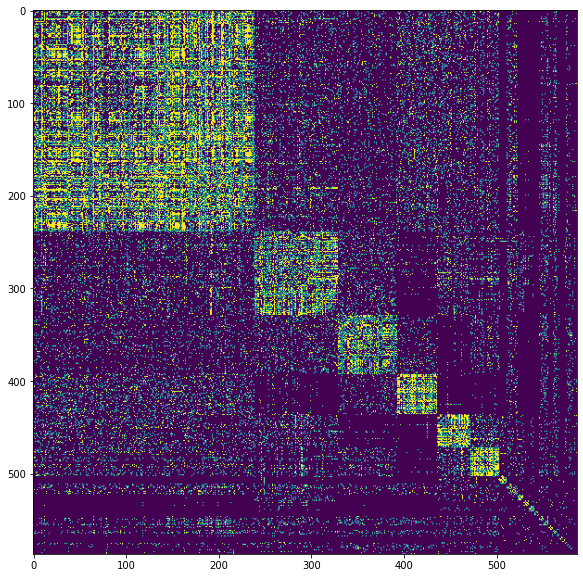

In [173]:
import h5py
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import leidenalg as la
import igraph as ig
import glob

%matplotlib inline

f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')

tuning = glob.glob('tuned_networks/2021-12-08-shadow_averages_0.01_0.1*')[0].split('/')[1]
i, j, s, t = f[tuning]['none']['sync'][:,:4].astype(int).T

at = 4900
m = (s <= at) & (t > at)
G = nx.Graph()
G.add_edges_from(zip(i[m], j[m]))
H = ig.Graph.from_networkx(G)
# compute the best partition
#partition = community_louvain.best_partition(G)

partition =  la.find_partition(H, la.CPMVertexPartition,
                                   resolution_parameter = 0.2);

print(max(partition.membership))

ig.plot(partition)

plt.figure(figsize=(15, 10))
o = np.array(partition.membership)
o = o.argsort()
A = nx.adjacency_matrix(G).toarray()
A = A[np.ix_(o, o)]
plt.imshow(A)

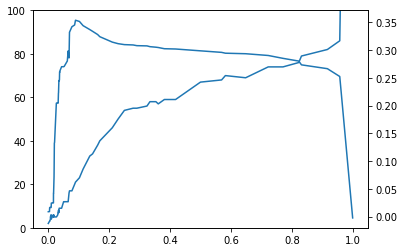

In [158]:
f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')

tuning = glob.glob('tuned_networks/2021-12-08-shadow_averages_0.01_1.0_*')[0].split('/')[1]
i, j, s, t = f[tuning]['none']['sync'][:,:4].astype(int).T

at = 4900
m = (s <= at) & (t > at)
G = nx.Graph()
G.add_edges_from(zip(i[m], j[m]))
H = ig.Graph.from_networkx(G)

optimiser = la.Optimiser()
profile = optimiser.resolution_profile(H, la.CPMVertexPartition,
                                       resolution_range=(0,1))
plt.plot([p.resolution_parameter for p in profile], [max(p.membership) for p in profile])
plt.ylim([0, 100])
plt.gca().twinx().plot([p.resolution_parameter for p in profile], [p.modularity for p in profile])

In [181]:
import h5py
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import leidenalg as la
import igraph as ig
import glob
import plotly as py
import plotly.graph_objects as go
import collections

%matplotlib inline

f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')

tuning = glob.glob('tuned_networks/2021-12-08-shadow_averages_0.01_0.1*')[0].split('/')[1]
i, j, s, t = f[tuning]['none']['sync'][:,:4].astype(int).T

partitions = {}
for at in range(0, 20000, 100):
    m = (s <= at) & (t > at)
    G = nx.Graph()
    G.add_edges_from(zip(i[m], j[m]))
    H = ig.Graph.from_networkx(G)
    partition =  la.find_partition(H, la.CPMVertexPartition,
                                       resolution_parameter = 0.2);
    partitions[at] = partition

In [187]:
import collections

In [194]:
l = {at: p.membership for at, p in partitions.items()}

hits = collections.defaultdict(int)
names = collections.defaultdict(lambda: len(names))

k = 1000
for at in range(0, 20000, k):
    if at + k not in partitions:
        continue
    prv = partitions[at].membership
    nxt = partitions[at + k].membership
    for a, b in zip(prv, nxt):
        hits[names[at, a], names[at + k, b]] += 1

source = []
target = []
values = []

for (a, b), v in hits.items():
    source.append(a)
    target.append(b)
    values.append(v)

In [203]:
fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 10,
      thickness = 1,
      #line = dict(color = "black", width = 0.5),
      #label = ["A1", "A2", "B1", "B2", "C1", "C2"],
      color = "black"
    ),
    link = dict(
      source = source,
      target = target,
      value  = values,
        color = 'black'
  ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)

fig.show()

# Plotting

## Synchronization (RDF)

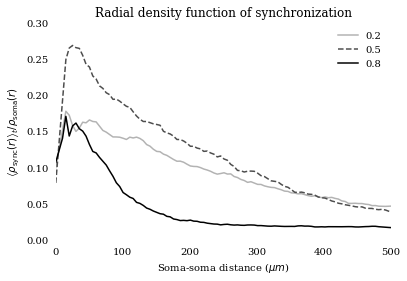

In [41]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
%matplotlib inline

plt.rc('font', family='serif')

keys = '''021-12-08-shadow_averages_0.01_0.0_965ef6ef-67f4-4903-a90d-efd8e361dc7d
2021-12-08-shadow_averages_0.01_0.1_7c60a825-0f18-48eb-85b5-15891617c0ac
2021-12-08-shadow_averages_0.01_0.2_5e889db2-932e-4e73-ba07-0772e4fa6a4a
2021-12-08-shadow_averages_0.01_0.3_4a2657f8-e7e9-4c15-ae11-a2edcac108fc
2021-12-08-shadow_averages_0.01_0.4_2dc970f8-41c0-4a0d-9a73-083f986023bf
2021-12-08-shadow_averages_0.01_0.5_3447248c-68a1-4860-b512-39fa22a5fa86
2021-12-08-shadow_averages_0.01_0.6_b07556b1-21fa-47e6-9021-20072df022c6
2021-12-08-shadow_averages_0.01_0.7_ff526814-9232-4074-8473-16a99676c3ab
2021-12-08-shadow_averages_0.01_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be
2021-12-08-shadow_averages_0.01_0.9_ada2023a-4377-409b-a5ce-02b6768ffe41
2021-12-08-shadow_averages_0.01_1.0_751ac228-3e2f-4d28-9894-6972386c6977'''.splitlines()

f = h5py.File('imgdata/rdf.h5', 'r')
selected = [2,5,8]
kwargs = [
    dict(color='0.7', ls='solid'),
    dict(color='0.3', ls='dashed'),
    dict(color='k', ls='solid')
]
for i, kw in zip(selected, kwargs):
    rdf = np.array(f[f'{keys[i]}/none/rdf'])
    rdf2 = savgol_filter(rdf, 5, 1)
    r = np.array(f[f'{keys[i]}/none/r'])
    ggap = np.array(f[f'{keys[i]}/none/ggap']).item()
    coef = np.array(f[f'{keys[i]}/none/coef']).item()
    #rdf[0] = np.nan
    plt.plot(r, rdf2, label=f'{coef}', **kw)
plt.xlabel('Soma-soma distance ($\\mu m$)')
plt.ylabel(r'$\left<\rho_{\mathrm{sync}}(r)\right>_t / \rho_{\mathrm{soma}}(r)$')
plt.legend(frameon=False)
plt.ylim([0, 0.3])
plt.xlim([0, 500])
plt.title('Radial density function of synchronization')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(bottom = False, left=False)

# Synchronization (sync)

In [172]:
import h5py
import iopublic
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

f = h5py.File('/home/llandsmeer/Data/database.h5', 'r')
tuning = '2021-12-08-shadow_averages_0.01_0.5_3447248c-68a1-4860-b512-39fa22a5fa86'
#tuning = '2021-12-08-shadow_averages_0.001_1.0_751ac228-3e2f-4d28-9894-6972386c6977'
network = iopublic.get_network_for_tuning(tuning)
sync = np.array(f[tuning]['none']['sync'])

Text(0, 0.5, 'Neuron (gid)')

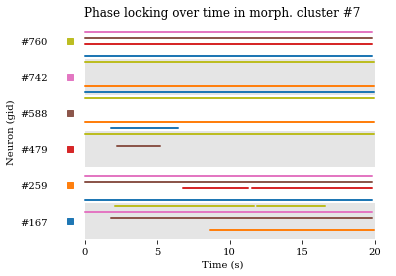

In [181]:
selected = 7

plt.rc('font', family='serif')

C = np.array([neuron.cluster for neuron in network.neurons])
#C = np.random.permutation(C)
mask = (C[sync[:,0].astype(int)] == selected) & (C[sync[:,1].astype(int)] == selected)
i, j, s, t = sync[mask, :4].astype(int).T
neurons = list(sorted(set(i) | set(j)))
ii = np.array([neurons.index(x) for x in i])
jj = np.array([neurons.index(x) for x in j])

#plt.figure(figsize=(14, 10))

cmap = plt.get_cmap('tab10')

def getc(i):
    return cmap(i / len(neurons))
    if i % 2 == 0:
        return '0.9'
    return 'white'

ticks = []
ticklabels = []

for idx, I in enumerate(neurons):
    #plt.axhline(idx*I0, color='black', lw=1)
    I0 = len(neurons)
    ticks.append(I0*idx + I0 / 2)
    ticklabels.append(f'#{I}')
    plt.plot(-1, idx*I0 + I0/2, 's', color=getc(idx))
    if idx % 2 == 0: 
        plt.fill_between([0, 20], [I0*idx, I0*idx], [I0*idx+I0, I0*idx+I0], color='black', alpha=0.1, edgecolor="none")
    for jdx, J in enumerate(neurons):
        m = (i == I) & (j == J)
        for ss, tt in zip(s[m], t[m]):
            plt.plot([ss/1e3, tt/1e3], [0.5+I0*idx + jdx, 0.5+I0*idx + jdx], color=getc(jdx), lw=2, solid_capstyle='round')
#plt.axhline(idx*I0+I0, color='black', lw=1)

#plt.axvline(0, color='black', lw=1)

plt.yticks(ticks, ticklabels)
plt.ylim([ticks[0]-I0/2-0.1, ticks[-1]+I0/2+0.1])      
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(left=False)

plt.title(f'Phase locking over time in morph. cluster #{selected}')
plt.xlabel('Time (s)')
plt.ylabel('Neuron (gid)')

# Control

2021-12-08-shadow_averages_0.001_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be


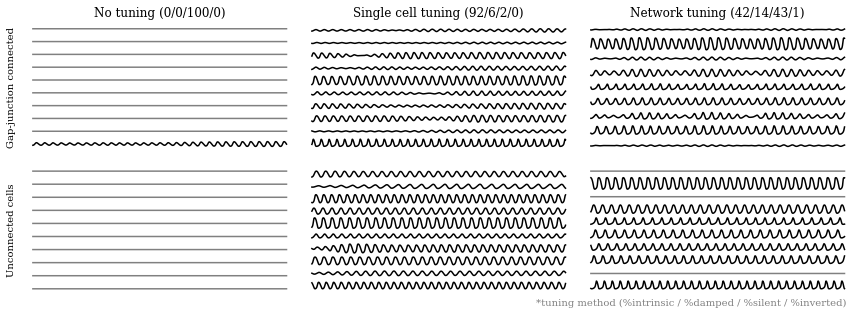

In [123]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rc('font', family='serif')
Csel = 32
th = 1

f = h5py.File('imgdata/control_tuning.h5', 'r')
for key in f.keys():
    print(key)

    tuning_methods = [
        dict(key='none', idx=0, name='No tuning'),
        dict(key='sc',   idx=1, name='Single cell tuning'),
        dict(key='tune', idx=2, name='Network tuning')
    ]

    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0, hspace=0.1)
    #plt.suptitle(f'{key}')
    C = np.array(f[key]['C'])
    for entry in tuning_methods:
        conn = np.array(f[key][entry['key']]['conn']).ptp(1) > th
        unconn = np.array(f[key][entry['key']]['unconn']).ptp(1) > th
        Nint = (conn & unconn).sum() / len(conn) * 100
        Ndamp = (conn & ~unconn).sum() / len(conn) * 100
        Ninv = (~conn & unconn).sum() / len(conn) * 100
        Nsilent = (~conn & ~unconn).sum() / len(conn) * 100
        ax[0, entry['idx']].set_title(f'{entry["name"]} ({Nint:.0f}/{Ndamp:.0f}/{Nsilent:.0f}/{Ninv:.0f})')
        for k in 'conn', 'unconn':
            vs = np.array(f[key][entry['key']][k])
            
            vs = vs[Csel == C]
            n = vs.shape[1]
            t = np.arange(n)
            m = vs.shape[0]
            
            for i, v in enumerate(vs):
                v = (v - v.mean()) / 20
                color = 'black'
                if np.isnan(v).any() or v.ptp() < th / 20:
                    color = '0.5'
                    v = np.zeros_like(v)
                a.plot(t, i + v, color=color)
                a = ax[1 - int(k == 'conn'), entry['idx']]
                #a.set_title(f'{"connected" if k == "conn" else "unconnected"}')
            a = ax[int(k == 'conn'), entry['idx']]
            a.set_xticks([])
            a.set_yticks([])
            a.spines['top'].set_visible(False)
            a.spines['right'].set_visible(False)
            a.spines['bottom'].set_visible(False)
            a.spines['left'].set_visible(False)
    ax[0, 0].set_ylabel('Gap-junction connected')
    ax[1, 0].set_ylabel('Unconnected cells')
    ax[1,2].set_xlabel('*tuning method (%intrinsic / %damped / %silent / %inverted)', horizontalalignment='right', position=(0.96,15), color='gray')
    break

## IR Space

20 *
62 x
180 1
376 +
547 D


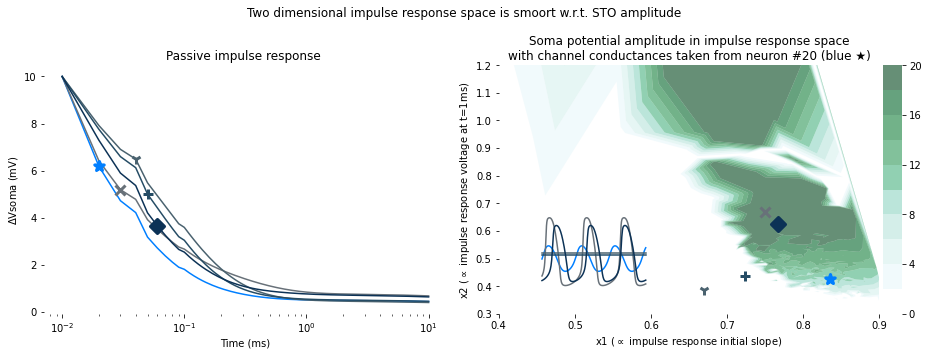

In [25]:

import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

colors = plt.get_cmap('BuGn')(np.linspace(0, 1, 11))
colors[0] = (1, 1, 1, 1)
#colors[-1] = (1, 0, 0, 1)
cm = ListedColormap(colors)

%matplotlib inline

Csel = 32

f = h5py.File('imgdata/control_tuning.h5', 'r')
tuning = '2021-12-08-shadow_averages_0.001_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be'
simdata = f[tuning]
vs = np.array(simdata.get('gid20/unconn'))
x1 = np.array(simdata.get('x1'))
x2 = np.array(simdata.get('x2'))
C = np.array(simdata.get('C'))
vstune = np.array(simdata.get('vstune'))

#gid20 = np.sqrt((x1-x1[20])**2 + (x2-x2[20])**2)
#gid20[gid20>1] = 1
ptp20 = vs[20].ptp()
gid20 = vs.ptp(1)
gid20 = np.nan_to_num(gid20)

fig, ax = plt.subplots(ncols=2, figsize=(13, 5))

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)

gid20[gid20 >= 20] = 19
tcf = ax[1].tricontourf(x1, x2, gid20, cmap=cm, levels=11, alpha=.6, antialiased=True)

markers = '*x1+D'
ai = ax[1].inset_axes([0.1, 0.1, 0.3, 0.3])
for i, gid in enumerate([20] + list(np.where(C == Csel)[0][::2][:4])):
    t = (np.arange(len(vstune[gid])) + 1) * 0.01
    if i == 0:
        cc = c = '#007fff'
    else:
        cc = f'{(i-1)/4:.1f}'
        c = 'black'
        cc = c = np.array(plt.get_cmap('Blues')(i/5))
        c[:3] /= 2
    ax[0].plot(t, 10 - vstune[gid], color=cc)
    l = 1 + i
    print(gid, markers[i])
    ax[0].scatter(t[l],(10 - vstune[gid])[l], [100], marker=markers[i], linewidths=[3], color=cc, zorder=100)
    ax[1].scatter(x1[gid], x2[gid], [100], marker=markers[i], linewidths=[3], color=c)
    ai.plot(vs[gid, :300], color=cc)
ax[0].set_xscale('log')
ai.axis('off')
#ax[0].set_yscale('log')

#ax[1].scatter(x1[20], x2[20], [100], marker='*', linewidths=[3], color='red')

ax[1].set_xlim([0.4, 0.9])
ax[1].set_ylim([0.3, 1.2])
ax[1].set_xlabel('x1 ($\\propto$ impulse response initial slope)')
ax[1].set_ylabel('x2 ($\\propto$ impulse response voltage at t=1ms)')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].spines['left'].set_visible(False)
plt.tick_params(left=False, bottom=False)

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].spines['left'].set_visible(False)
plt.tick_params(left=False, bottom=False)

ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('$\\Delta$Vsoma (mV)')
#ax[0].set_xlim([1, len(vstune[0])])

cb = fig.colorbar(tcf, cax=cax, orientation='vertical', )
cb.outline.set_visible(False)

ax[0].set_title('Passive impulse response ')
ax[1].set_title('Soma potential amplitude in impulse response space\nwith channel conductances taken from neuron #20 (blue ★)')
plt.suptitle('Two dimensional impulse response space is smoort w.r.t. STO amplitude')
plt.tight_layout();

plt.rcParams['figure.facecolor'] = 'white'

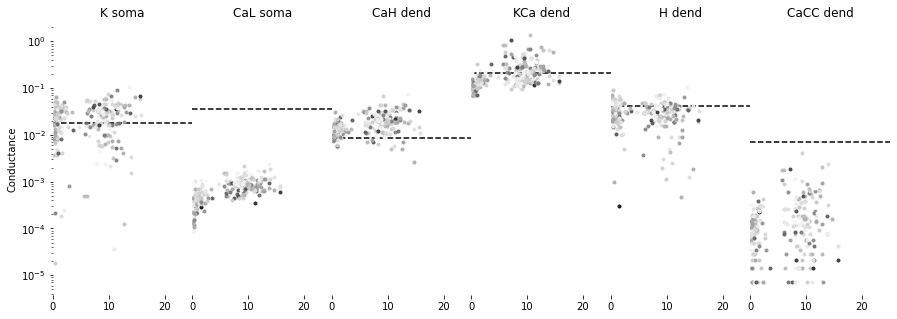

In [104]:
import json
import h5py
import matplotlib.pyplot as plt
import numpy as np

selected = '2021-12-08-shadow_averages_0.001_0.8_d1666304-c6fc-4346-a55d-a99b3aad55be'
f = h5py.File('imgdata/control_tuning.h5', 'r')
x1 = np.array(simdata.get('x1'))
x2 = np.array(simdata.get('x2'))
simdata = f[selected]

names = 'scal_ks', 'scal_cal', 'scal_cah', 'scal_kca', 'scal_h', 'scal_cacc'
zeros = 0.015 * 1.2, \
        0.030 * 1.2, \
        0.010 * 1.7 / 2, \
        0.200 * 0.7 * 1.5, \
        0.025 * 1.7, \
        0.007
readable = 'K soma', 'CaL soma', 'CaH dend', 'KCa dend', 'H dend', 'CaCC dend'

cm = plt.get_cmap('gray')

fig, ax = plt.subplots(ncols = len(names), figsize=(15, 5), sharey=True)
plt.subplots_adjust(wspace=0)

with open(f'tuned_networks/{selected}') as f:
    tuning = json.load(f)
for gid, (mod, pop) in enumerate(zip(tuning['mods'], tuning['subpops'])):
    if gid % 3 != 0:
        continue
    #if abs(pop['vamp_shadow'] - 10) < 2:
    #    pass
    #else:
    #    continue
    if not all(k in names for k in mod):
        continue
    for k, v in mod.items():
        i = names.index(k)
        v1 = pop['vamp_shadow']
        v2 = (x1[gid] - 0.4) * 2
        ax[i].plot(v1, v * zeros[i], '.', color=cm(v2))
for i, (n, z) in enumerate(zip(readable, zeros)):
    ax[i].set_title(n)
    ax[i].set_xlim([0, 25])
    ax[i].axhline(z, ls='--', zorder=-100, color='black')
    ax[i].set_yscale('log')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['bottom'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    if i > 0:
        #ax[i].set_yticks([])
        #plt.setp(ax[i].get_xticklabels(), visible=False)
        ax[i].yaxis.set_ticks_position('none')
ax[0].set_ylabel('Conductance');